<a href="https://colab.research.google.com/github/Rishabh672003/Learning-machine-learning/blob/main/Stock_Overflow_label_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [11]:
url = "https://github.com/Rishabh672003/Learning-machine-learning/raw/main/NLP-Internship-Project/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')

6057178/6057178 [==============================] - 0s 0us/step


In [12]:
os.listdir(dataset_dir)

['test', 'train', 'README.md']

In [13]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'python', 'java', 'javascript']

In [14]:
sample_file = os.path.join(train_dir, 'csharp/1.txt')
with open(sample_file) as f:
  print(f.read())

"get the y axis height of webbrowser control document i am trying to get the height of a document in a web browser control...at the moment i'm using the code below but it always returns 622 and i know my documents are all different sizes...private void webcomparesql_documentcompleted(object sender, webbrowserdocumentcompletedeventargs e).        {.            htmldocument htmldoc = webcomparesql.document;.           int scrollhight = htmldoc.window.position.y;.        }...can someone please show me the right way to do this?"



In [16]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [17]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [18]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [19]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [20]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [21]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [23]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [24]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [25]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [27]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"function expected error in blank for dynamically created check box when it is clicked i want to grab the attribute value.it is working in ie 8,9,10 but not working in ie 11,chrome shows function expected error..&lt;input type=checkbox checked=\'checked\' id=\'symptomfailurecodeid\' tabindex=\'54\' style=\'cursor:pointer;\' onclick=chkclickevt(this);  failurecodeid=""1"" &gt;...function chkclickevt(obj) { .    alert(obj.attributes(""failurecodeid""));.}"\n', shape=(), dtype=string)
Label javascript
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  38,  450,   65,    7,   16,   12,  892,  265,  186,  451,   44,
          11,    6,  685,    3,   46,    4, 2062,    2,  485,    1,    6,
         158,    7,  479,    1,   26,   20,  158,    7,  479,    1,  502,
          38,  450,    1, 1767, 1763,    1,    1,    1,    1,    1,    1,
           1,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [50]:
print("128 ---> ",vectorize_layer.get_vocabulary()[128])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

128 --->  result
 313 --->  source
Vocabulary size: 10000


In [51]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [58]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [59]:
embedding_dim = 16

In [63]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 16)          160000    
                                                                 
 dropout_8 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_4  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160068 (625.27 KB)
Trainable params: 160068 (625.27 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [64]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=["accuracy"])

In [65]:
epochs = 20
r = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
200/200 [==============================] - 2s 8ms/step - loss: 1.3801 - accuracy: 0.3348 - val_loss: 1.3703 - val_accuracy: 0.4719
Epoch 2/20
200/200 [==============================] - 2s 10ms/step - loss: 1.3541 - accuracy: 0.4642 - val_loss: 1.3336 - val_accuracy: 0.5175
Epoch 3/20
200/200 [==============================] - 2s 10ms/step - loss: 1.3053 - accuracy: 0.5384 - val_loss: 1.2746 - val_accuracy: 0.5656
Epoch 4/20
200/200 [==============================] - 1s 7ms/step - loss: 1.2373 - accuracy: 0.5864 - val_loss: 1.2019 - val_accuracy: 0.6256
Epoch 5/20
200/200 [==============================] - 1s 7ms/step - loss: 1.1597 - accuracy: 0.6389 - val_loss: 1.1259 - val_accuracy: 0.6706
Epoch 6/20
200/200 [==============================] - 1s 7ms/step - loss: 1.0810 - accuracy: 0.6823 - val_loss: 1.0520 - val_accuracy: 0.7006
Epoch 7/20
200/200 [==============================] - 1s 7ms/step - loss: 1.0080 - accuracy: 0.7148 - val_loss: 0.9854 - val_accuracy: 0.7206
Epoc

In [66]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 5ms/step - loss: 0.6383 - accuracy: 0.7780
Loss:  0.6383484601974487
Accuracy:  0.777999997138977


In [67]:
history_dict = r.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

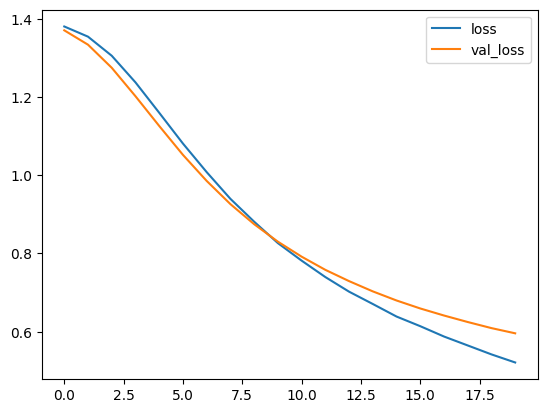

In [68]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

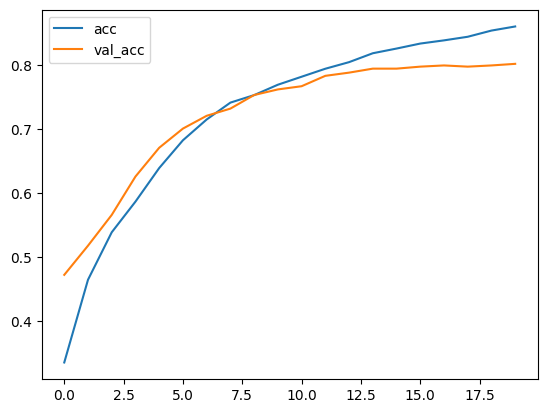

In [69]:
plt.plot(r.history['accuracy'], label = "acc")
plt.plot(r.history['val_accuracy'], label = "val_acc")
plt.legend();